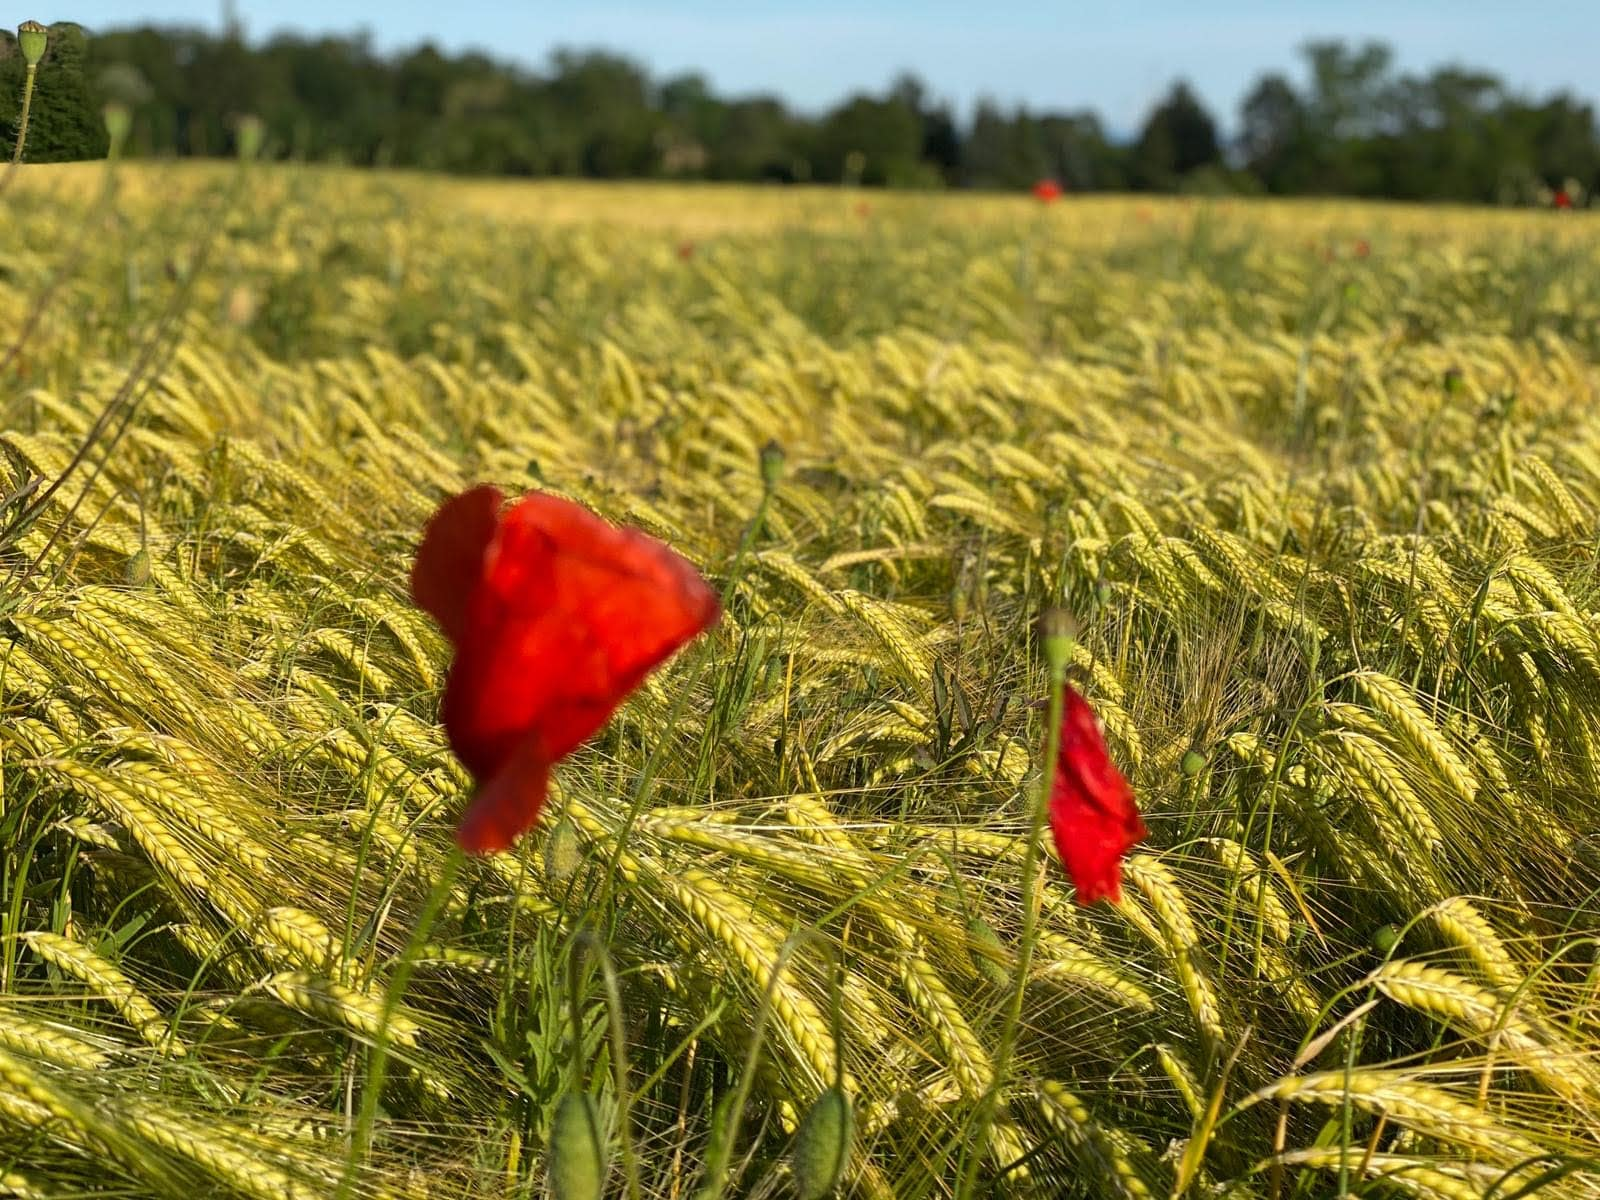

### EDITS/REWORKS:
V12: Corrections, enhanced readability

V10: Typo correction, slight changes & additions  

V9: fixed a bug in Inference (used predictions for the wrong image) --> now predictions amtch ground-truth much better

## Quick Intro: Dear Farmgirls, dear Farmboys..
this is my first object detection Kaggle competition! 
Please feel free to give me some hints for improvements in all categories: making code more "pythonic", better graphics, ideas for pre & post-processing, etc.


# Competition description
Open up your pantry and you’re likely to find several wheat products. Indeed, your morning toast or cereal may rely upon this common grain. Its popularity as a food and crop makes wheat widely studied. To get large and accurate data about wheat fields worldwide, plant scientists use image detection of "wheat heads"—spikes atop the plant containing grain. These images are used to estimate the density and size of wheat heads in different varieties. Farmers can use the data to assess health and maturity when making management decisions in their fields.
However, accurate wheat head detection in outdoor field images can be visually challenging. There is often overlap of dense wheat plants, and the wind can blur the photographs. Both make it difficult to identify single heads. Additionally, appearances vary due to maturity, color, genotype, and head orientation. Finally, because wheat is grown worldwide, different varieties, planting densities, patterns, and field conditions must be considered.

Wheat is a staple across the globe, which is why this competition must account for different growing conditions. Models developed for wheat phenotyping need to be able to generalize between environments. If successful, researchers can accurately estimate the density and size of wheat heads in different varieties. With improved detection farmers can better assess their crops, ultimately bringing cereal, toast, and other favorite dishes to your table.

### What should I expect the data format to be?
The Global Wheat Head Dataset is led by nine research institutes from seven countries: the University of Tokyo, Institut national de recherche pour l’agriculture, l’alimentation et l’environnement, Arvalis, ETHZ, University of Saskatchewan, University of Queensland, Nanjing Agricultural University, and Rothamsted Research.
The Data needs to be submitted in Coco-style format: x, y, width and height.

### What am I predicting?
In this competition, you’ll detect wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe. Using worldwide data, you will focus on a generalized solution to estimate the number and size of wheat heads. To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. You will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.



# Faster RCNN Intro
## Architectural overview
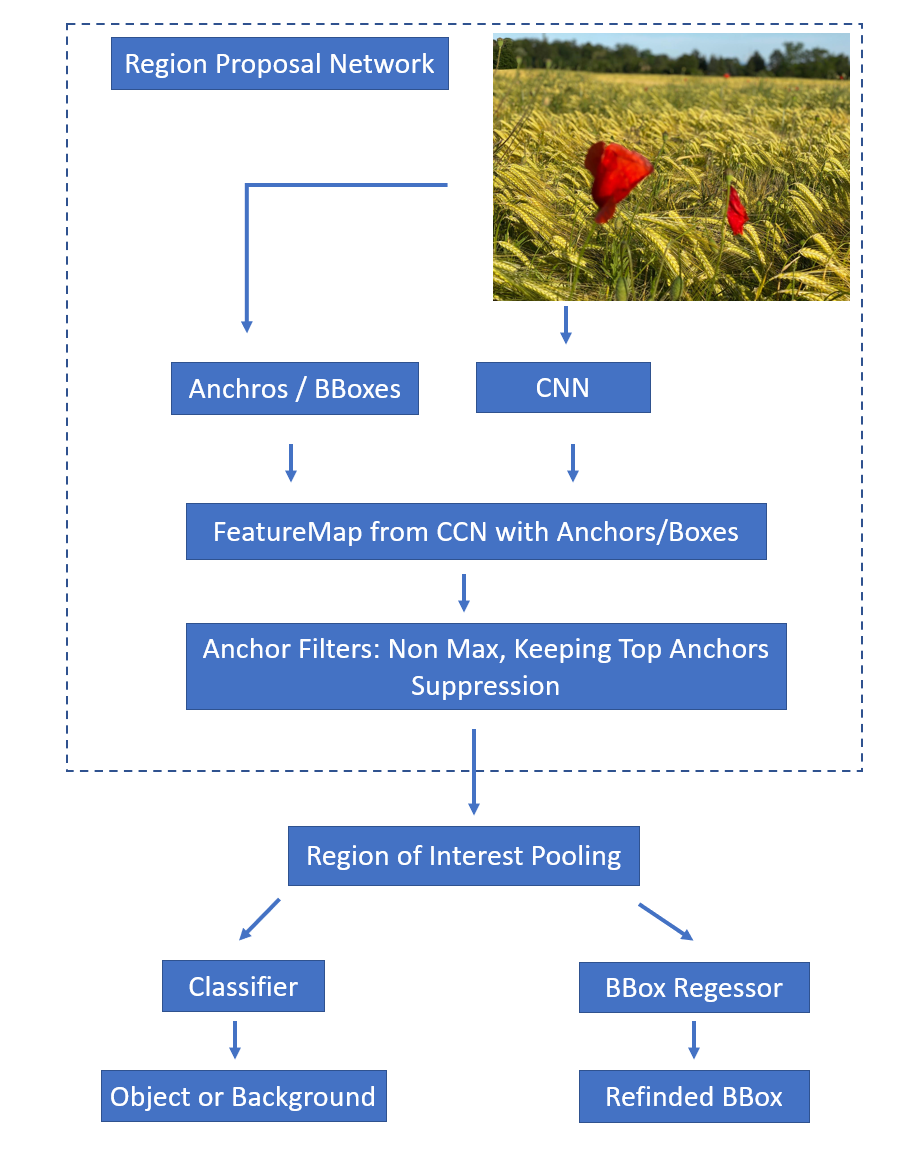




## How Faster-RCNN works:  

1) **Region Proposal Network** (RPN) step 1: Run the image through a CNN to get a **Feature Map** and project Anchors or BBoxes onto this map.  

2) (RPN) step 2: Keep only the best anchors (e.g. top 2000), and discard the rest. This is achieved using only anchors with IoU < 0.4 for background and > 0.7 for objects and after that  applying non-max suppression.  

3) Do **Region of interest** pooling ([ROI Pooling](https://blog.deepsense.ai/region-of-interest-pooling-explained/): this leads to uniformly sized outputs which can be used for classification and BBOX regression  

4) For the **Classification** task ( = is it background or object?) binary cross entropy (BCE) is used to calculate the loss.   

5) The **BBOX regressor** calculates offsets based on the anchors from step 2) and the regression loss is calculated.  


More in depth literatur on how anchor boxes are created and how ROI pooling works in detail can be found here:
https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/  
https://medium.com/@smallfishbigsea/faster-r-cnn-explained-864d4fb7e3f8  
https://medium.com/@whatdhack/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd  
https://towardsdatascience.com/fasterrcnn-explained-part-1-with-code-599c16568cff    


## Special info about the pytroch implementation we are going to use.
* As you can see in many [github implementations](https://github.com/pytorch/vision/blob/d2c763e14efe57e4bf3ebf916ec243ce8ce3315c/torchvision/models/detection/faster_rcnn.py#L227) and the (kinda hard to find) [official pytroch implementation](https://pytorch.org/docs/stable/_modules/torchvision/models/detection/faster_rcnn.html#fasterrcnn_resnet50_fpn), the minimum Image size for FasterRCNN is 800 and the maximum is 1333. So resizing to below 800 (most notebooks use 512 for training) before feeding it in the network is not only unnecessary computational cost, but also decreasing the information contained in the pictures.
* Images should not be normalized during augmentation-process or in your Dataset-class. Subtracting the mean and dividing by std. deviation is automatically done in the [GeneralizedRCNNTransform](https://github.com/pytorch/vision/blob/39021408587eb252ebb842a54195d840d6d76095/torchvision/models/detection/transform.py)-Class which is used by the model itself! 


## Importing dependencies
<span style="color:darkgreen ;font-family: Impact; font-size:13;"> from  </span> coffee  <span style="color:darkgreen ;font-family: Impact; font-size:13;"> import  </span> ***** 

In [ ]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm import tqdm_notebook as tqdm # progress bar
import matplotlib.pyplot as plt

# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

# torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# sklearn
from sklearn.model_selection import StratifiedKFold

# CV
import cv2

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Glob
from glob import glob

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

In [ ]:
# Lets check our Hardware first
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

# Configuration

## Basic configuration for this model

Below you can change the base configuration, the impact on CV and LB score is quite high! Be careful to not choose a too high learning rate.

In [ ]:
n_folds = 5
seed = 2020
num_classes = 2
BATCH_SIZE = 4
LR = 0.05

## Use more then 20 Epochs, we go for 20 epochs for demonstration purposes
EPOCHS = 20
img_size_training = 800

## Choose your optimizers:
Adam = False
if Adam: 
    Adam_config = {"lr" : 0.001, "betas" : (0.9, 0.999), "eps" : 1e-08}
else:
    SGD_config = {"lr" : 0.001, "momentum" : 0.9, "weight_decay" : 0.001}

# Seed Everything

Seeding everything for reproducible results.

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(seed)

# Preparing the Data

For creating a cross-validation strategy we use code from Alex's awesome [kernel](https://www.kaggle.com/shonenkov/training-efficientdet).
We will create a cross-validation split in which the folds are made by preserving the percentage of samples (= stratisfied!) for each of the following "classes":
* number of boxes 
* source

For this we first check the data:

In [ ]:
bboxes_df = pd.read_csv('../input/global-wheat-detection/train.csv')
bboxes_df.head()

And then unpack the bbox coordinates into seperate columns x, y, w, h.

In [ ]:
# get an array of arrays of all bboxes in the form [[x], [y], [w], [h]]
bboxs = np.stack(bboxes_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep = ',')))
# save the values in the respective column
for i, column in enumerate(['x', 'y', 'w', 'h']):
    bboxes_df[column] = bboxs[:,i]
bboxes_df.drop(columns=['bbox'], inplace=True)
bboxes_df.head()

In [ ]:
# Creating stratified Folds
skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = seed)

df_folds = bboxes_df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1

# get number of bboxes for each image_id
df_folds = df_folds.groupby('image_id').count()

# add [source] column
df_folds.loc[:, 'source'] = bboxes_df[['image_id', 'source']].groupby('image_id').min()['source']

# concat two arays of strings: source and (_bboxcount // 15) to separate into folds
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str))
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(        
        X = df_folds.index,
        y = df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

# Creating Dataset
## Let's raise a glass* to create the Dataset!
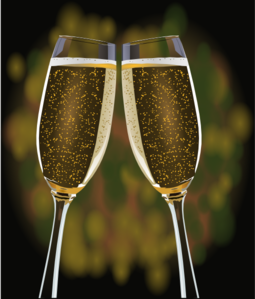

*class

In [ ]:
DIR_TRAIN = '../input/global-wheat-detection/train'

class WheatDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms = None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # converting from Coco to Pascal_voc format        
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        # calculate area of bbox
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one target class: wheat 
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        """
        What is 'iscrowd' meaning and doing?:
        iscrowd: For single, seperable objects iscrowd is set to zero.
        If we want to do segmentation, for a closeby group or collection of objects
        in the image, we set iscrowd=1, in which case RLE is used.
        """
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            # if this creates issues, use target['boxes'] = torch.as_tensor(sample['bboxes']) instead of below line
            # target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = torch.as_tensor(sample['bboxes'])
            target['boxes'] = target['boxes'].float()
        
        return image, target, image_id

# Augmentations
Due to the limited size of the dataset and the fact, that Imagenet pre-trained FasterRCNNs don't know a lot about Wheathead-Detection yet, we will use a lot of different augmentations.
But: More augmentations are not always leading to better results. Also the augmentations need to be somewhat reasonable. So be careful to not augment every single picture multiple times: Using Albumentations ```OneOf``` method helps a lot here.
Using [Cutmix](https://arxiv.org/abs/1905.04899) in this competition is a very good idea to ensure good regulariazion/generalization of your network.

However, there are always things you should not do:
![](https://pbs.twimg.com/media/Ea4T7DxWsAEi4Ga.jpg)


In [ ]:
## Albumentations

def get_train_transforms():
    return A.Compose(
        [   A.OneOf([
                A.HueSaturationValue(hue_shift_limit = 0.2, 
                                     sat_shift_limit = 0.2,
                                     val_shift_limit = 0.2,
                                     p = 0.3), 
            
                A.RandomBrightnessContrast(brightness_limit = 0.2,                                             
                                           contrast_limit = 0.2,
                                           p = 0.3),
                # RGB shift normally expects not-normalized images, so make sure to normalize the RGB shift!
                A.RGBShift(r_shift_limit = 20/255, 
                           g_shift_limit = 20/255, 
                           b_shift_limit = 10/255,
                           p = 0.3)
            ], 
            p = 0.2),
         
            A.OneOf([
                A.RandomGamma(gamma_limit = (80, 120),
                              p = 0.3),
                A.Blur(p = 0.6),
                A.GaussNoise(var_limit = (0.01, 0.05), mean = 0, p = 0.05),
                A.ToGray(p = 0.05)
                ],
                p = 0.1),

            A.OneOf([
                A.HorizontalFlip(p = 1), 
                A.VerticalFlip(p = 1),  
                A.Transpose(p = 1),                
                A.RandomRotate90(p = 1)
                ], 
                p = 0.7),  
         
            A.RandomFog(fog_coef_lower = 0.1,
                        fog_coef_upper = 0.2,
                        p = 0.02),   
         
            A.RandomSizedBBoxSafeCrop(img_size_training, 
                                      img_size_training, 
                                      p = 0.05),         
            A.Resize(height = img_size_training, 
                     width = img_size_training, 
                     p = 1),
         
            A.Cutout(num_holes = random.randint(1, 6),
                     max_h_size = 64, 
                     max_w_size = 64,
                     fill_value = 0, 
                     p = 0.15),
         
            ToTensorV2(p = 1.0),
        ],
        p = 1.0, bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transforms():
    return A.Compose([
        A.Resize(height = img_size_training,
                 width = img_size_training,
                 p = 1),
        
        ToTensorV2(p = 1.0)
    ], bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']})

# Validate Augmentations

It's always strongly recommended to check your input pictures into your model after augmentations, to ensure that not strange things happen.

I've seen (and also accidently used)  
```A.RGBShift(r_shift_limit = 20, 
            g_shift_limit = 20,
            b_shift_limit = 10,
            p = 0.3)```    
in a training pipeline for normalized pictures, and guess what happend: They turned in completely yellow, blue or red. Why? Because RGBSHift expectes not-normalized pictures! So be sure you normalize RGB shift to get valid input data -->  
```A.RGBShift(r_shift_limit = 20/255, 
            g_shift_limit = 20/255,
            b_shift_limit = 10/255, 
            p = 0.3)```

In [ ]:
## In several occasions in the next sections we will need to create a dataset and a dataloader.
# In this section we create helper functions for this to stay DRY (dont repeast yourself).

def get_validation_datset(df):
    return WheatDataset(
    image_ids = df.index.values,
    dataframe = bboxes_df,
    transforms = get_valid_transforms()
    )
    
def get_train_datset(df):    
    return WheatDataset(
    image_ids = df.index.values,
    dataframe = bboxes_df,
    transforms = get_train_transforms()
    )

def get_validation_data_loader(valid_dataset, batch_size = 16):
    return DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
    )    

def get_train_data_loader(train_dataset, batch_size = 16):
    return DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
    ) 

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
## Lets check some augmentations!

# get a fold
df_train = df_folds[df_folds['fold'] != 0]

# create train dataset and data-loader
train_dataset = get_train_datset(df_train)
train_data_loader = get_train_data_loader(train_dataset, batch_size = 16)

device=torch.device('cuda')
images, targets, image_ids = next(iter(train_data_loader))

images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# plot some augmentations!
fig, ax = plt.subplots(figsize=(20, 20),  
                       nrows = 4,
                       ncols = 4)
for i in range (16):    
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
    
    ax[i // 4][i % 4].imshow(sample)   

# Model



As mentioned in the introduction, we are using the default [ResNet50 pytroch implementation](https://kite.com/python/docs/torchvision.models.detection.fasterrcnn_resnet50_fpn) here.
We will start with defining a function to load and get the model, as we will be doing this several times in the later sections. Next, we will define an AverageMeter, tracking of the loss of our model.
Then we can finally set up the training.

In [ ]:
def get_model():    
    # load pre-trained model incl. head
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier custom head
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Training Function



In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    # initialize and reset to zero
    def __init__(self):
        self.reset()

    # reset everything to zero    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    # update loss after each batch
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_fn(data_loader,model,optimizer,device,scheduler,epoch):
    # set pytorch to train mode, in which the model will return losses
    model.train()
        
    summary_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total = len(data_loader))
    
    # actual training steps
    for step, (images, targets, image_ids) in enumerate(tk0):   
        
        # if targets is empty, create empty target tensor        
        if len(targets) < 1:
            target['boxes'] = torch.zeros((0, 4))
            
        # prepare data
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]        

        # calculate loss        
        loss_dict = model(images, targets)        
        losses = sum(loss for loss in loss_dict.values())
                
        # resets gradients of all optimized Tensors before next training step
        optimizer.zero_grad() 
        
        # computes derivative of the loss w.r.t. the parameters 
        losses.backward() 
        
        # updates the parameter based on the gradients from previous step
        optimizer.step()
        
        # updates the scheduler if it's defined
        if scheduler is not None:
            scheduler.step()
            
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss = summary_loss.avg)
        
    return summary_loss

# Evaluation Function

In order to select the best model, epoch & weights, we need to create a valid competition metric.
In this case, we take the very well coded version from [this notebook](https://www.kaggle.com/pestipeti/competition-metric-details-script). 

In [ ]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form = form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1
        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)



def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), 
                                                     preds, 
                                                     threshold = threshold,
                                                     form = form,
                                                     ious = ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision


In [ ]:
def eval_fn(data_loader, model, device):
    model.eval()
    summary_loss_eval = AverageMeter()
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
    validation_image_precisions = []
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            """
            In model.train() mode, model(images)  is returning losses.
            We are using model.eval() mode --> it will return boxes and scores. 
            """
            outputs = model(images)

            for i, image in enumerate(images):
                boxes = outputs[i]['boxes'].data.cpu().numpy()
                scores = outputs[i]['scores'].data.cpu().numpy()
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                preds_sorted_idx = np.argsort(scores)[::-1]
                preds_sorted = boxes[preds_sorted_idx]
                image_precision = calculate_image_precision(preds_sorted,
                                                            gt_boxes,
                                                            thresholds = iou_thresholds,
                                                            form = 'pascal_voc')
                validation_image_precisions.append(image_precision)

    valid_prec = np.mean(validation_image_precisions)
        
    return valid_prec

# Engine

In this section we will do the actual training, comining the previous defined functions to a full pipeline.

In [ ]:
def run(fold):
    summary_loss = AverageMeter()
    
    # split data in training and validation set based on the fold
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    # get data loaders
    train_dataset = get_train_datset(df_train)
    train_data_loader = get_train_data_loader(train_dataset, batch_size = BATCH_SIZE)
    
    validation_dataset = get_validation_datset(df_valid)
    validation_data_loader = get_validation_data_loader(validation_dataset, batch_size = 16)
          
    # get GPU device
    device = torch.device('cuda')
    
    # get model
    model = get_model()
    model = model.to(device)
    
    # get all trainable parameters for the optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    
    # get the configured optimizer
    if Adam:
        optimizer = torch.optim.Adam(params, **Adam_config)
    else:
        optimizer = torch.optim.SGD(params, **SGD_config)
        
    best_precision = 0.01
    for epoch in range(EPOCHS):
        
        # reset loss for each new epoch
        summary_loss.reset()
                                
        train_loss = train_fn(train_data_loader, 
                              model, optimizer, 
                              device, 
                              scheduler = None, 
                              epoch = epoch)
        
        valid_precision = eval_fn(validation_data_loader, 
                                  model,
                                  device)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VAL_PRECISION {}|'.format(
            epoch+1,
            train_loss.avg,
            valid_precision))
        
        if valid_precision > best_precision:
            best_precision = valid_precision
            print('Best model found for Epoch {}'.format(epoch+1))
            torch.save(model.state_dict(), f'FRCNN_best_{fold}.pth')

In [ ]:
run(fold = 0)

### The model works as expected: 
The loss is continuously dropping, the VAL_PRECISION is continuously increasing.
Using more epochs will lead to much better results and only the best model is saved in your OUTPUT folder.

# Sample visualization of predictions

In this step we load the best saved model and make our predictions.

In [ ]:
def view_sample(df_valid,model,device):
    '''
    Code merged from Peter's & KnowNothing's great Kernels
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr
    '''
    
    validation_dataset = get_validation_datset(df_valid)
    validation_data_loader = get_validation_data_loader(validation_dataset, batch_size = 16)
    
    # not needed
    # images, targets, image_ids = next(iter(validation_data_loader))
    # images = list(img.to(device) for img in images)
    # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    #_,h,w = images[0].shape # for de normalizing images
    
    images, targets, image_ids = next(iter(validation_data_loader))
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes_gt = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.to(device)
    model.eval()
    cpu_device = torch.device("cpu")
    #model.cuda()

    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # paint ground_truth boxes (red)
    for box in boxes_gt:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
        
    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
          
    # paint predicted boxes (blue)
    pred_box_count = 0
    for box,p in zip(boxes,scores):        
        if p >0.5:
            pred_box_count += 1
            color = (0,0,220) 
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  color, 2)
    
    
    print(f"Predicted {pred_box_count} BBoxes (blue); Number of GT BBoxes (red) : {len(boxes_gt)}")
    ax.set_axis_off()
    ax.imshow(sample)       

  

In [ ]:
model = get_model()
# load the best saved weights
model.load_state_dict(torch.load("./FRCNN_best_0.pth"))
# show a prediction
view_sample(df_folds[df_folds['fold'] == 0],
            model = model,
            device = torch.device('cuda'))

As expected, using less than 20 Epochs is not enough. Good results can be achived with 40+ Epochs, mostly using Colab for longer notebook availability.

# Conclusion

As Yolov5 is not really allowed due to its GPLv3 license (see [discussions](https://www.kaggle.com/c/global-wheat-detection/discussion/163433)), most probably FasterRCCN, EfficientDet or a combination of their results will win this competition. 

Thank you for reading!